In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [28]:
# Definition of artificial Hamiltonian
def art_H(phi,p,J,beta_h,N):
    return ((p**2)/2)+((phi**2)/(2*J))-(N*np.log(2*np.cosh(beta_h+phi)))
#Definition of phi dot 
def phi_dot(p,phi):
    return p
#Definition of p dot
def p_dot(p,phi,J,beta_h,N):
    return (phi/J)-(N*np.tanh(beta_h+phi))


## Leapfrog algorithm

In [30]:
def ribbit(p_0,phi_0,Nmd,J,beta_h,N,trajectory_len=1):
    p_f=np.array(p_0)     # initialize p
    phi_f= np.array(phi_0) # and phi

    epsilon=trajectory_len/Nmd # define the step size

    #p_f=p_f+0.5*epsilon*p_dot(p_f,phi_f,J,beta_h,N) # first half step for p

    phi_f=phi_f+(0.5*epsilon*phi_dot(p_f,phi_f))

    for i in range(Nmd):        
        p_f=p_f-epsilon*p_dot(p_f,phi_f,J,beta_h,N) # full step for p 
        phi_f=phi_f+epsilon*phi_dot(p_f,phi_f)      # full step for phi 
        
        

    phi_f=phi_f-(0.5*epsilon*phi_dot(p_f,phi_f))
    #p_f=p_f-.5*epsilon*p_dot(p_f,phi_f,J,beta_h,N)  #we go back half step for p

    return p_f,phi_f


## Convergence test

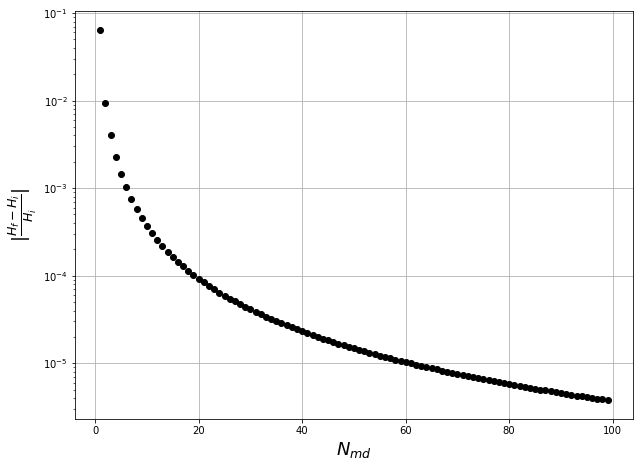

In [31]:
phi_init=-2     # we initialize to random values for the test
p_init=2

beta_h=0.5      # here again 
J=1
N=1

#Calculation of the first hamiltonian 
H_start=art_H(phi_init,p_init,J,beta_h,N)

#definition of the array for N_md
Nmd_array = [i for i in range(1,100,1)]
#storage list for the difference of H_end and H_start
deltaH=[]

#Implimentation of leap-frog algorithm 
for Nmd in Nmd_array:
    p_f,phi_f= ribbit(p_init,phi_init,Nmd,J,beta_h,N)
    H_end=art_H(phi_f,p_f,J,beta_h,N) #taking Hamiltonian after the leap-frog
    deltaH.append(abs((H_end-H_start)/H_start)) #Saving the deltaH

#ploting the convergence
fig, ax = plt.subplots(1,1,figsize=(10,7.5))
ax.plot(Nmd_array,deltaH,'ko')
ax.set_yscale('log')
ax.set_xlabel(r'$N_{md}$',fontsize=18)
ax.set_ylabel(r'$\left|\frac{H_f-H_i}{H_i}\right|$',fontsize=18)
ax.grid()


## Implimentation of HMC

In [35]:
# Initialization of the variables to test the functionality of HMC
Nmd=30     
phi=[0]
prob=[]
nTraj=10000

J=1
beta_h=0.5
N=5

#Implimentation of HMC
for traj in range(nTraj):
    p_start=np.array([np.random.uniform(0,1)]) #Initialization of p with a random variable [0,1]
    phi_start=phi[-1]                          #Taking the last element of phi which changes with the accept/reject method 
    H_start_HMC=art_H(phi_start,p_start,J,beta_h,N) #Calculation of initial Hamiltonian

    p_out,phi_out=ribbit(p_start,phi_start,Nmd,J,beta_h,N) #Evolve with leap-frog

    H_end_HMC=art_H(phi_out,p_out,J,beta_h,N)  # Calculate Hamiltonian after leap-frog

    if np.random.uniform(0,1) <= np.exp(-(H_end_HMC-H_start_HMC)): #Accept/Reject with exp(-(H_end-H_start))
        phi.append(phi_out)
        prob.append(1)
    else:
        phi.append(phi_start)
        prob.append(0)


In [36]:
prob.count(1)/len(prob)

1.0

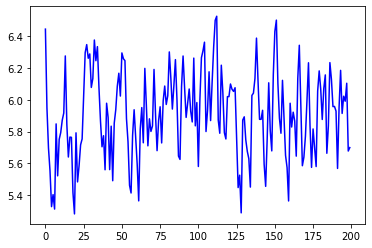

In [34]:
plt.plot(phi[500:700],"b-") #Plot to verify that the algorithm worked

From the plots we get the thermalisation time, which differs for different J

## Calculations

In [8]:
#Here we impliment the function calculated in question 1
def m_phi(phi,beta_h):
    return np.tanh(beta_h+phi)

def energy_phi(phi,J,beta_h,N):
    h=beta_h
    return (1/(2*N))-((phi**2)/(2*J))-(np.tanh(beta_h+phi)*h)

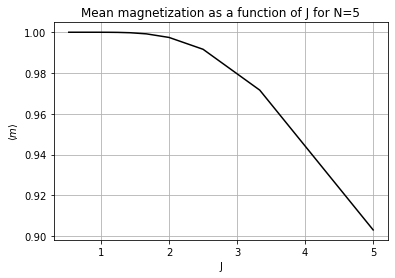

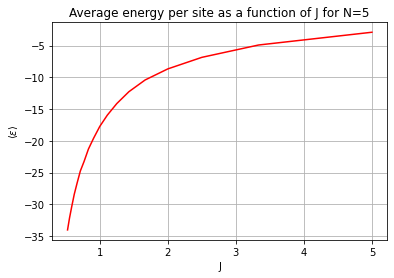

In [9]:
#We set an acceptable N_md so that acceptance rate is <50%
N_md=10

#We set values as needed
beta_h=0.5
J_range=np.arange(.2,2,0.1)

#number of N that changes to
N=5                      #5,10,15,20

#With these values for thermalization and trajectories for every N take around 2-3 minutes per run
nTherm=100 
nTraj=1000

#initialize lists to store our measurements
mean_magnetization=[]
avg_energy_per_site=[]

# we loop over for different J
for J in J_range:
    phi=[0]         # initialize phi and the probability list 
    prob=[]
    #Thermalize with the HMC
    temp_phi=phi[-1]
    for traj in range(nTherm):
        p_start=np.array([np.random.uniform(0,1)])
        phi_start=temp_phi
        H_start_HMC=art_H(phi_start,p_start,J,beta_h,N)
        
        p_out,phi_out=ribbit(p_start,phi_start,Nmd,J,beta_h,N)

        H_end_HMC=art_H(phi_out,p_out,J,beta_h,N)

        if np.random.uniform(0,1)<=np.exp(-(H_end_HMC-H_start_HMC)):
            temp_phi=phi_out
        else:
            temp_phi=phi_start
    phi=[temp_phi]

    #Run the HMC after the thermalization
    for trah in range(nTraj):
        p_start=np.array([np.random.uniform(0,1)])
        phi_start=phi[-1]    
        H_start_HMC=art_H(phi_start,p_start,J,beta_h,N)
        
        p_out,phi_out=ribbit(p_start,phi_start,Nmd,J,beta_h,N)

        H_end_HMC=art_H(phi_out,p_out,J,beta_h,N)

        if np.random.uniform(0,1)<=np.exp(-(H_end_HMC-H_start_HMC)):
            phi.append(phi_out)
            prob.append(1)
        else:
            phi.append(phi_start)
            prob.append(0)
    
    #Here we calculate the average phi after the thermalization
    sum_mag=0
    sum_e=0
    for i in range(len(phi)):
        sum_mag+=m_phi(phi[i],beta_h)
        sum_e+=energy_phi(phi[i],J,beta_h,N)
    avg_mag=sum_mag/len(phi)
    avg_e=sum_e/(len(phi))
    #Here we take the measurements for every J 
    mean_magnetization.append(avg_mag)
    avg_energy_per_site.append(avg_e)



#Plot for <m>
plt.plot(1/J_range,mean_magnetization,"k-")
plt.xlabel("J")
plt.ylabel(r'$\langle m \rangle$')
plt.title("Mean magnetization as a function of J for N={}".format(N))
plt.grid()
plt.show()
#Plot for <ε>
plt.plot(1/J_range,avg_energy_per_site,"r-")
plt.xlabel("J")
plt.ylabel(r'$\langle \epsilon \rangle$')
plt.title("Average energy per site as a function of J for N={}".format(N))
plt.grid()
plt.show()





In [37]:
prob.count(1)/len(prob)

1.0